## Imports

In [0]:
! pip install soundfile

In [0]:
import numpy as np
import tables
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split


### Some statistics

In [0]:
midi_statistics = np.load('midi_statistics.npy')

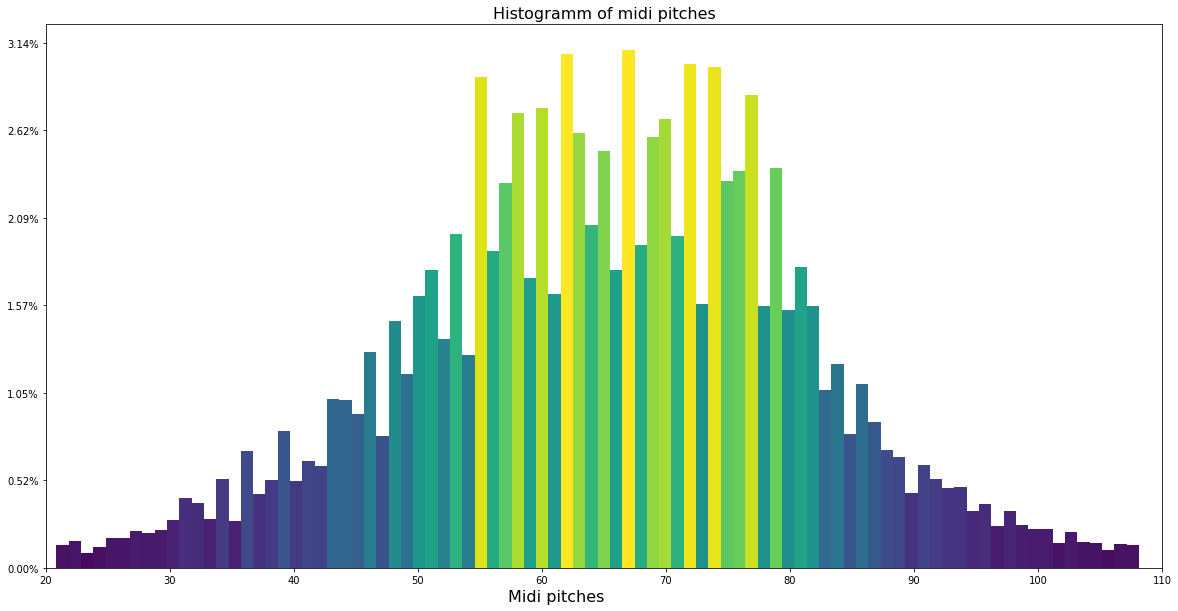

In [0]:
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([20,110])
# axes.set_ylim([ymin,ymax])
# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = plt.hist(np.arange(128), bins=128, weights=midi_statistics)
# We'll color code by height, but you could use any scalar
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# plt.grid(True)
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axes.set_title('Histogramm of midi pitches', fontdict = {'fontsize': 16})
axes.set_xlabel('Midi pitches', fontdict = {'fontsize': 16, 'horizontalalignment': 'right'})
# Now we format the y-axis to display percentage
axes.yaxis.set_major_formatter(PercentFormatter(xmax=np.sum(midi_statistics)))
plt.show()

# Data preparing 
**specifically for MAPS dataset**

### Про термины **sample** и **frame** (sample < frame)

A **sample** is the smallest usable quantum of digital audio.

The term **frame** isn't formally defined in pure audio terms, but is often used in relation to video that may accompany an audio track. In that context a frame is the quantity of audio samples taken during a video frame interval.

### Про константу MIN_SAMPLES_PRESENT из config.py
According to my copy of the absolutely essential (!) Master Handbook of Acoustics, to hear shorter tones, that is sounds with a short impulse, they need to be louder:

A 1,000-Hz tone sounds like 1,000 Hz in a 1-second tone burst, but an extremely short burst sounds like a click. The duration of such a burst also influences the perceived loudness. Short bursts do not sound as loud as longer ones... A pulse 3 milliseconds long must have a level about 15dB higher to sound as loud as a 0.5-second (500 millisecond) pulse. Tones and random noise follow roughly the same relationship in loudness vs. pulse length.

The 100-msec region is significant... Only when the tones or noise bursts are shorter than this amount must the sound-pressure level be increased to produce a loudness equal to that of long pulses or steady tones or noise. This 100 msec appears to be the integrating time or the time constant of the human ear. (Everest 2001, 60-61)

## Launching from Google Collab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/multipitch_estimation')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Utillity functions

In [0]:
'''
Функция форматирования времени для вывода дебаг-информации
'''
def format_time(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    print('{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds)))

In [0]:
def normalize_data(X):
  X /= np.linalg.norm(X, axis=1, keepdims=True)

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
'''
Проверяет, существуют ли на самом деле файлы в поданной 
на вход triplet, состоящей из .wav, .mid и .txt файлов
'''

def check_file_triplet_valid(triplet):
    for filename in triplet:
        if os.path.isfile(filename):
            continue
        else:
            raise Exception("The given file doesn't exist")
    return True

In [0]:
'''
В указанной директории находит все файлы с расширением .wav
и соответствующие им файлы с раширением .mid, .txt, 
составляет из них так называемый triplet и сохраняет в выходной массив
'''
def collect_files_from_directory(directory_path):
  
    collected_files = []
    
    for f in os.scandir(directory_path):
      
        if f.is_dir():
            for (dirpath, dirnames, filenames) in os.walk(f.path):
                for file in filenames:
                    if file.endswith(".wav"):
                        fullpath = dirpath + '/' + file # forms the path to the file
                        base = os.path.splitext(fullpath)[0] # gets the path to the file without its extention
                        triplet = [base + '.wav', base + '.mid', base + '.txt'] # forms the triplet of files: .wav, .mid, .txt
                        if check_file_triplet_valid(triplet):
                            collected_files.append(triplet)
                            
        elif f.is_file():
            if f.name.endswith(".wav"):
                fullpath = directory_path + '/' + f.name
                base = os.path.splitext(fullpath)[0]
                triplet = [base + '.wav', base + '.mid', base + '.txt']
                if check_file_triplet_valid(triplet):
                    collected_files.append(triplet)
                      
    return np.array(collected_files)


In [0]:
''' 
.wav файл считывается библиотекой Soundfile как многомерный массив с шейпом (None, sound_channels)
Данная функция преобразует только двухканальные аудиофайлы: сливает их в один канал.
Остальные (не двухканальные) аудиофайлы оставляет неизменными.
'''
def make_mono_audiofile(data):
    if data.shape[1] == 2:
        data = (data[:, 0] + data[:,1]) / 2
    return data
        
''' 
Полагает, что на вход подается pandas.DataFrame.
В его полях "OnsetTime" и "OffsetTIme" переводит время в секундах в номер sample'а
'''
def translate_time_to_sample_number(data):
    data["OnsetTime"] = np.round(data.values[:, 0] * SAMPLERATE).astype(int)
    data["OffsetTime"] = np.round(data.values[:, 1] * SAMPLERATE).astype(int)
    return data

In [0]:
# returns frames (numpy.ndarray of the shape (None, WINDOW_SIZE))
# and labels (numpy.ndarray of the shape (None, MIDI_PITCH_NUM))) for an audiofile
def preprocess_audiofile(path_wav, path_txt):
    
    # data (numpy.ndarray) – a two-dimensional NumPy array is returned,
    # where the channels are stored along the first dimension, i.e. as columns. 
    data_wav, samplerate = sf.read(path_wav)
    data_txt = pd.read_csv(path_txt, sep="\t", header=0)

    assert(samplerate==SAMPLERATE)
    
    data_wav = make_mono_audiofile(data_wav)
    data_txt = translate_time_to_sample_number(data_txt)
    chunks_amount = len(data_wav) // WINDOW_SIZE
    samples_amount = WINDOW_SIZE * chunks_amount
    # отбрасываем конец аудиофайла, если количество
    # сэмплов в нем НЕ делится ровно на WINDOW_SIZE
    data_wav = data_wav[:samples_amount] 
    
    # делим data_wav на одинаковые chunks_amount, если длина data_wav
    # НЕ делится ровно на chunks_amount, то np.split должен будет выбросить exception
    frames = np.array(np.split(data_wav, chunks_amount))
    labels = np.array(get_labels_for_audiofile(data_txt, frames))
    
    if DEBUG_MODE:
        print("==== preprocessing file: {} ====".format(path_wav))
        print("frames shape: {}".format(frames.shape))
        print("labels shape: {}".format(labels.shape))
        assert frames.shape[0] == labels.shape[0], "frames.shape[0] should be equal to labels.shape[0]"
    return frames, labels
    

In [0]:
def get_labels_for_audiofile(data_txt, frames):
    
    # Для каждого frame'a заданного размера WINDOW_SIZE хотим создать label,
    # который представляет из себя вектор из 0 и 1 размера MIDI_PITCH_AMOUNT,
    # обозначающий, звучала ли соответствующая нота во время этого frame'a или нет
    # инициализируем все нулями
    labels = np.zeros((len(frames), MIDI_PITCH_AMOUNT), dtype=int)
    
    for i in np.arange(data_txt.shape[0]):

        onset_time = data_txt.values[i][0]
        offset_time = data_txt.values[i][1]
        midi_pitch = data_txt.values[i][2]
        midi_statistics[midi_pitch] += 1
        
        begin_frame = onset_time // WINDOW_SIZE
        end_frame = offset_time // WINDOW_SIZE
        
        
        for frame_num in np.arange(begin_frame, end_frame + 1):
            
            if frame_num == begin_frame:
                if (((begin_frame + 1) * WINDOW_SIZE - 1) - onset_time) > MIN_SAMPLES_PRESENT:
                    # помечаем, что данный midi_pitch звучал в рассматриваемом frame'e
                    labels[begin_frame][midi_pitch] = 1
                    continue
            if frame_num == end_frame:
                if (offset_time - (end_frame * WINDOW_SIZE)) > MIN_SAMPLES_PRESENT:
                    labels[end_frame][midi_pitch] = 1
                    continue
                    
            # если между begin_frame и end_frame есть хотя бы один frame, то очевидно,
            # что данный midi_pitch звучал на протяжении всего frame'a
            labels[frame_num][midi_pitch] = 1

    return labels
    

In [0]:
def preprocess_all_audiofiles(files, name_to_save):
  
    start_time = time.time()
    X_buffer = np.empty((0,WINDOW_SIZE), float)
    y_buffer = np.empty((0,MIDI_PITCH_AMOUNT), int)
    num_files = len(files)
    
    X_filename = 'preprocessed_data/X_' + name_to_save + '.h5'
    y_filename = 'preprocessed_data/y_' + name_to_save + '.h5'
    atom_float = tables.Float64Atom()
    atom_int = tables.Int8Atom()
    try: 
        f_X = tables.open_file(X_filename, mode='w')
        f_X.create_earray(f_X.root, 'data', atom_float, (0, WINDOW_SIZE))
        print("---- current X shape: {}".format(f_X.root.data.shape))
        f_X.close()

        f_y = tables.open_file(y_filename, mode='w')
        f_y.create_earray(f_y.root, 'data', atom_int, (0, MIDI_PITCH_AMOUNT))
        f_y.close()


        for i in np.arange(len(files)):

            print("! {}/{}".format(i, num_files))

            file_triplet = files[i]
            file_data, file_labels = preprocess_audiofile(file_triplet[0], file_triplet[2])
            normalize_data(file_data)
            X_buffer = np.concatenate((X_buffer, file_data), axis=0)
            y_buffer = np.concatenate((y_buffer, file_labels), axis=0)
            
            print("---- current X_buffer shape: {}".format(X_buffer.shape))
            print("---- current y_buffer shape: {}".format(y_buffer.shape))


            if (i % 100 == 0):

                X_buffer, y_buffer = unison_shuffled_copies(X_buffer, y_buffer)

                f_X = tables.open_file(X_filename, mode='a')
                f_X.root.data.append(X_buffer)
                print("---- current X shape: {}".format(f_X.root.data.shape))
                f_X.close()

                f_y = tables.open_file(y_filename, mode='a')
                f_y.root.data.append(y_buffer)
                print("---- current y shape: {}".format(f_y.root.data.shape))
                f_y.close()

                X_buffer = np.empty((0,WINDOW_SIZE), float)
                y_buffer = np.empty((0,MIDI_PITCH_AMOUNT), int)
                clear_output()

         # ====== ending       
        X_buffer, y_buffer = unison_shuffled_copies(X_buffer, y_buffer)
        f_X = tables.open_file(X_filename, mode='a')
        f_X.root.data.append(file_data)
        print("---- current X shape: {}".format(f_X.root.data.shape))
        f_X.close()

        f_y = tables.open_file(y_filename, mode='a')
        f_y.root.data.append(file_labels)
        print("---- current y shape: {}".format(f_y.root.data.shape))
        f_y.close()
        # =======

        f_X = tables.open_file(X_filename, mode='a')
        print("============ OVERALL X shape: {} ============".format(f_X.root.data.shape))
        f_X.close()

        f_y = tables.open_file(y_filename, mode='a')
        print("============ OVERALL y shape: {} ============".format(f_y.root.data.shape))
        f_y.close()

        end_time = time.time()
        elapsed_time = format_time(end_time - start_time)
        print("Elapsed time: {}".format(elapsed_time))
    finally:
      
      f_X.close()
      f_y.close()
      print("Files have been closed!")

In [0]:
def collect_specific_files(subname, file_triplets):
    result = []
    for triplet in file_triplets:
        filename = triplet[0]
        if filename.startswith(subname):
            result.append(triplet)
    return np.array(result)

## Processing

### Collect all files
Находим все аудиофайлы в директории REL_PATH (объявлена в config.py)



In [0]:
files_all = collect_files_from_directory(REL_PATH)
print("files_all shape: {}".format(files_all.shape))

### Split on train and test
Делим их на train и на test, и на всякий случай сохраняем, какие файлы являются train'ом, а какие test'ом.

In [0]:
files_train, files_test = train_test_split(files_all, test_size=0.2, random_state=42)
np.save("preprocessed_data/files_train_names", files_train)
np.save("preprocessed_data/files_test_names", files_test)
files_train.shape, files_test.shape

### The contents of MAPS is divided in four sets:
* the ISOL set: isolated notes and monophonic excerpts
* the RAND set: chords with random pitch notes
* the UCHO set: usual chords from Western music
* the MUS set: pieces of piano music

In [0]:
files_train_rand = collect_specific_files("ENSTDkCl/RAND", files_train)
files_train_isol = collect_specific_files("ENSTDkCl/ISOL", files_train)
files_train_ucho = collect_specific_files("ENSTDkCl/UCHO", files_train)
files_train_mus = collect_specific_files("ENSTDkCl/MUS", files_train)

In [0]:
assert(files_train.shape[0] == (files_train_rand.shape[0] + files_train_isol.shape[0] + files_train_ucho.shape[0] + files_train_mus.shape[0]))
files_train_rand.shape, files_train_isol.shape, files_train_ucho.shape, files_train_mus.shape


In [0]:
files_test_rand = collect_specific_files("ENSTDkCl/RAND", files_test)
files_test_isol = collect_specific_files("ENSTDkCl/ISOL", files_test)
files_test_ucho = collect_specific_files("ENSTDkCl/UCHO", files_test)
files_test_mus = collect_specific_files("ENSTDkCl/MUS", files_test)

In [0]:
assert(files_test.shape[0] == (files_test_rand.shape[0] + files_test_isol.shape[0] + files_test_ucho.shape[0] + files_test_mus.shape[0]))
files_test_rand.shape, files_test_isol.shape, files_test_ucho.shape, files_test_mus.shape


### Data processing

#### Train

In [0]:
preprocess_all_audiofiles(files_train, "train")

In [0]:
preprocess_all_audiofiles(files_train_isol, "train_isol")

In [0]:
preprocess_all_audiofiles(files_train_rand, "train_rand")

In [0]:
preprocess_all_audiofiles(files_train_ucho, "train_ucho")

In [0]:
preprocess_all_audiofiles(files_train_mus, "train_mus")

#### Test

In [0]:
preprocess_all_audiofiles(files_test, "test")

In [0]:
preprocess_all_audiofiles(files_test_isol, "test_isol")

In [0]:
preprocess_all_audiofiles(files_test_rand, "test_rand")

In [0]:
preprocess_all_audiofiles(files_test_ucho, "test_ucho")

In [0]:
preprocess_all_audiofiles(files_test_mus, "test_mus")